In [1]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

os.makedirs('utils/', exist_ok=True)
os.chdir('utils')

! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/vision.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/callbacks.py
! wget https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/utils.py

os.chdir('/content')
print("Current working directory", os.getcwd())

--2023-11-09 09:24:03--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15061 (15K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]  14.71K  --.-KB/s    in 0.001s  

2023-11-09 09:24:03 (19.6 MB/s) - ‘models.py’ saved [15061/15061]

--2023-11-09 09:24:04--  https://raw.githubusercontent.com/Ata-Pab/Machine_Learning/master/utils/losses.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6436 (6.3K) [text/plain]
Savi

In [4]:
from utils import vision
from utils import utils
from utils import losses

### ToDo

* Implement 'Content Loss' for reconstruction loss (OK)

* Generate normal samples using GAN and feed the CVAE with (normal samples + GAN generated samples)

* Use GAN to learn normal samples distribution and then use the discriminator loss to get anomaly score

### Experiment Parameters

In [5]:
experiment = {
    'TYPE': 'train',        # Experiment type: 'train', 'test'
    'ACCELERATOR': 'GPU',   # 'GPU' or 'TPU'

    'IMAGE_SIZE': (512, 512),
    'INPUT_SHAPE': (512, 512, 3),
    'VALID_SIZE': 0.0,      # Validation data size: (Valid Data) / (All Data)
    'DATA_AUG': True,       # Apply data augmentation

    'BACKBONE': 'custom',        # 'custom', 'VGG16', 'VGG19' - default 'custom'
    'LAST_TRANIABLE_LAYERS': 5,  # number of last trainable layers of pre-trained backbone models, fine-tuning
    'BATCH_SIZE': 8,            # IF TPU is active set 4, otherwise set anything
    'EPOCHS': 1000,
    'OPTIMIZER': 'Adam',  # TODO: Try 'rmsprop' optimizer
    'LEARNING_RATE': 1e-5,

    'RECONS_LOSS': 'MSE',  # Reconstruction loss ('SSIM', 'MSE', 'MAE', 'PERCEPTUAL')
    'PERCEPTUAL_LAYERS': [5,8,13,18],    # [5,8,13,18], None
    'PERCEP_LOSS_MODEL': 'VGG19', # custom', 'VGG16', 'VGG19' - default 'VGG16'
    'PERP_LOSS_LAMBDA': 1,
    'LRELU_SLOPE': 0.2,       # Leaky ReLU activation function slope value
    'MSE_LOSS_LAMBDA': 0.01,  # MSE coeff

    # set the dimensionality of the latent space to a plane for visualization later
    'LATENT_DIM': 500,

    'SAVE_WEIGHTS_PER_EPOCH': 10,
    # Record directory of model's trained weights
    'TRAINING_WEIGHT_DIR': "tf_vae/BD67_dataset/training_weights",
    # Record directory of generated images
    'IMGS_DIR': "tf_vae/BD67_dataset/images",
}

### Determining Reconstructing Loss Function

* **MSE** (Mean Squared Error): Pixel-Wise Reconstruction Loss, L2 rergularization (Ridge)
MSE = Σ (pixel_original - pixel_reconstructed)^2 / N

* **MAE** (Mean Absolute Error): Pixel-Wise Reconstruction Loss, L1 rergularization (Lasso)
MAE = Σ (pixel_original - pixel_reconstructed) / N

* **Feature-Wise Reconstruction Loss**: A common approach is to use a `perceptual loss` or `content loss`, which compares the high-level features or activations of intermediate layers of a pre-trained neural network
1. Encode the input image into a latent vector using the pre-trained model (encoder). Ex. `VGG19 model`

2. Reconstruct an image from latent vector using the decoder.

3. Calculate the loss based on the similarity between the input image and the reconstructed image.

In [6]:
if experiment['ACCELERATOR'] == 'TPU':
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
    tf.config.experimental_connect_to_cluster(resolver)

    # This is the TPU initialization code that has to be at the beginning.
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
    # Increase batch_size to improve the efficiency provided by TPU usage
    experiment['BATCH_SIZE'] = experiment['BATCH_SIZE'] * strategy.num_replicas_in_sync
    print("All devices:  ", tf.config.list_logical_devices('TPU'))
    print("All replicas: ", strategy.num_replicas_in_sync)
else:
    strategy = tf.distribute.get_strategy()

In [7]:
# Process batches as much as per_replica_batch_size per TPU
per_replica_batch_size = experiment['BATCH_SIZE'] // strategy.num_replicas_in_sync

In [8]:
print("Number of cores(replicas) in sync: ", strategy.num_replicas_in_sync)
print("Batch size: ", experiment['BATCH_SIZE'])
print("Batch size per replica: ", per_replica_batch_size)

Number of cores(replicas) in sync:  1
Batch size:  8
Batch size per replica:  8


In [9]:
ROOT_PATH = '/content'
DATASET_PATH = '/content/drive/MyDrive/MASTER/Master_Thesis/Dataset/BD67_Dataset'

In [10]:
import os

BD67_NORMAL_PATH = os.path.join(DATASET_PATH, 'defect_free')
BD67_NORMAL_FRONT_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/cropped')
BD67_NORMAL_FRONT_ROTATED_PATH = os.path.join(DATASET_PATH, 'defect_free/Front/rotated_images/cropped')
BD67_NORMAL_REAR_PATH = os.path.join(DATASET_PATH, 'defect_free/Rear')
BD67_DEFECTED_FRONT_PATH = os.path.join(DATASET_PATH, 'defected/Front/cropped')
BD67_DEFECTED_REAR_PATH = os.path.join(DATASET_PATH, 'defected/Rear')

### Read TFRecord File

In [11]:
import shutil

if experiment['ACCELERATOR'] == 'TPU':
    # Use the shutil.copy() method to copy the TFRecord file in Google drive to the local workspace
    shutil.copy(TFRECORD_TRAIN_PATH, ROOT_PATH)
    shutil.copy(TFRECORD_TEST_PATH, ROOT_PATH)

In [12]:
TFRECORD_TRAIN_PATH_LOCAL = '/content/images.tfrecords'
TFRECORD_TEST_PATH_LOCAL = '/content/images_test.tfrecords'

In [13]:
# Create a dictionary describing the features.
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.int64),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
}

In [14]:
# Returns "File system scheme '[local]' not implemented (file: '/bufferedio/content/images.tfrecords')" Error
# The dataset should be stored in GCS (Google Cloud Storage)
# image_dataset = utils.read_tfRecord_image('/content/images.tfrecords', image_feature_description)

### Prepare Data

In [15]:
img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_PATH, 'png')
rotated_img_files = utils.get_image_file_list(BD67_NORMAL_FRONT_ROTATED_PATH, 'png')
all_img_files = img_files + rotated_img_files

print("Number of flat image files: ", len(img_files))
print("Number of rotated image files: ", len(rotated_img_files))
print("Number of all image files: ", len(all_img_files))

Number of flat image files:  110
Number of rotated image files:  105
Number of all image files:  215


### Data Augmentation Layer

In [16]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  #preprocessing.RandomFlip("horizontal_and_vertical"), # randomly flip images on horizontal/vertical edge
  #preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  #preprocessing.RandomZoom(0.2), # randomly zoom into an image
  tf.keras.layers.RandomBrightness(factor=0.2, value_range=[0.0, 1.0], seed=None),
  # value_range parameter should be [0.0, 1.0] for RandomBrightness
  # if images were scaled before, default value is [0,255]
  tf.keras.layers.RandomContrast(0.2, seed=None),
  #tf.keras.layers.RandomCrop(256, 256, seed=None), Error - Image size changes
  #preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  #preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  #preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

In [17]:
def apply_augmentation(image):
    image = data_augmentation(image, training=True)  # Apply data augmentation layers
    return image

In [21]:
train_dataset = utils.create_dataset_pipeline(img_files, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'], scl=True, shuffle=False, num_channels=3, rot=utils.ROT_0, aug_layer=data_augmentation, data_aug_power=2, accelerator='GPU')

In [22]:
train_dataset

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None)>

In [24]:
print("Number of batches to be trained: ", len(train_dataset))

Number of batches to be trained:  42


* The `cache()` method is used to cache elements of a dataset in memory or on disk. Caching allows you to `store a portion` or the entire `dataset` in a format that can be quickly accessed during training `without repeatedly reading the data from its source` (e.g., files on disk). It helps reduce data loading time during training. When you call dataset.cache(), it caches the dataset's elements in memory by default. If you want to cache to disk, you can provide a filename as an argument to the cache() method. Caching can significantly speed up training if data loading is a bottleneck in your pipeline.

* The `prefetch()` method is used to `overlap data loading` and model training, which can lead to improved training performance. When you prefetch data, the dataset pipeline `fetches` the `next batch` of data asynchronously `while the current batch is being processed` by the model. This can help hide data loading latency and ensure that the GPU or CPU is fully utilized during training.

* `tf.data.experimental.AUTOTUNE` is used as an argument to the prefetch() method. This value allows TensorFlow to `dynamically adjust` the number of elements prefetched based on the `available system resources` and workload. It tries to optimize the prefetching for the best performance automatically.

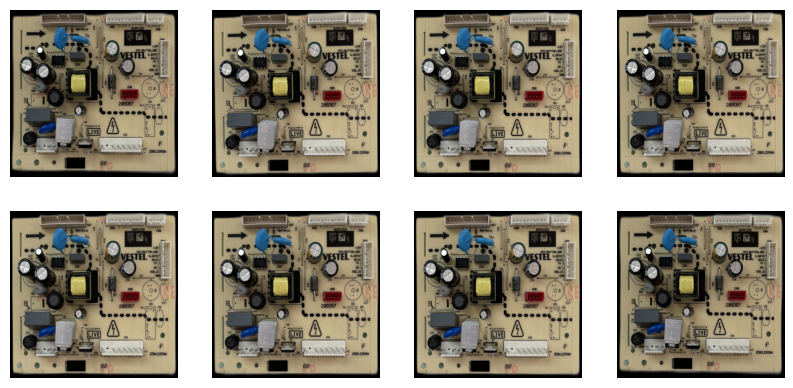

In [25]:
vision.show_image_samples_from_batch(train_dataset, grid=(4,4))

In [26]:
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Reshape, Flatten, Conv2DTranspose, MaxPooling2D, UpSampling2D, Add
from tensorflow.keras.layers import LeakyReLU, Lambda, ReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import layers

In [27]:
from sklearn.model_selection import train_test_split
import math

# Get number of training batches according to VALID_SIZE
training_batch_num = len(train_dataset) - math.ceil(len(train_dataset) * experiment['VALID_SIZE'])

# Prepare new training and validation batches
train_dataset_part = train_dataset.take(training_batch_num)
valid_dataset_part = train_dataset.skip(training_batch_num)

# training_files, valid_files, _, _ = train_test_split(training_files, training_files, test_size=experiment['VALID_SIZE'], random_state=100)

#print(f"Number of Training Images: {len(training_files)}")
#print(f"Number of Validation Images: {len(valid_files)}")

print("Number of training batches:   ", len(train_dataset_part))
print("Number of validation batches: ", len(valid_dataset_part))

Number of training batches:    42
Number of validation batches:  0


In [28]:
if experiment['ACCELERATOR'] == 'TPU':
  train_dataset_replica = strategy.distribute_datasets_from_function(
          lambda _: utils.get_replica_dataset(train_dataset, per_replica_batch_size, is_training=True))

In [29]:
# steps_per_epoch = len(training_files) // experiment['BATCH_SIZE']
steps_per_epoch = len(train_dataset_part)
print("Steps per epoch: ", steps_per_epoch)

Steps per epoch:  42


### Convolutional Variational Autoencoder Architecture

### Encoder Network

This defines the approximate posterior distribution `q(z|x)`, which takes as input an observation and outputs a set of parameters for specifying the conditional distribution of the latent representation `z`. In this example, simply model the distribution as a `diagonal Gaussian`, and the network outputs the `mean` and `log-variance` parameters of a factorized Gaussian. Output `log-variance` instead of the variance directly for numerical stability.

In [30]:
from tensorflow.keras import layers

In [31]:
if experiment['BACKBONE'] == 'custom':
  def create_encoder_model(input_encoder, latent_dim):
      inputs = keras.Input(shape=input_encoder, name='input_layer')

      #if experiment['DATA_AUG'] == True:
      #    inputs = data_augmentation(inputs)

      # Block-1
      x = layers.Conv2D(32, kernel_size=3, strides= 2, padding='same', name='conv_1')(inputs)
      x = layers.BatchNormalization(name='bn_1')(x)
      x = layers.LeakyReLU(name='lrelu_1')(x)

      # Block-2
      x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
      x = layers.BatchNormalization(name='bn_2')(x)
      x = layers.LeakyReLU(name='lrelu_2')(x)

      # Block-3
      x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
      x = layers.BatchNormalization(name='bn_3')(x)
      x = layers.LeakyReLU(name='lrelu_3')(x)

      # Block-4
      x = layers.Conv2D(64, 3, 2, padding='same', name='conv_4')(x)
      x = layers.BatchNormalization(name='bn_4')(x)
      x = layers.LeakyReLU(name='lrelu_4')(x)

      # Block-5
      x = layers.Conv2D(64, 3, 2, padding='same', name='conv_5')(x)
      x = layers.BatchNormalization(name='bn_5')(x)
      x = layers.LeakyReLU(name='lrelu_5')(x)

      # Final Block
      flatten = layers.Flatten()(x)  # (None, 7, 7, 64) to (None, 3136)

      # Latent variables
      mean = layers.Dense(latent_dim, name='mean')(flatten)
      log_var = layers.Dense(latent_dim, name='log_var')(flatten)
      # Model
      model = Model(inputs, (mean, log_var), name="Encoder")

      model.summary()
      keras.utils.plot_model(model, "encoder_model.png")
      return model

### Improved VGG19 Architecture for Anomaly Detection

![](https://www.researchgate.net/publication/359771670/figure/fig5/AS:11431281079634597@1660789329088/VGG-19-Architecture-39-VGG-19-has-16-convolution-layers-grouped-into-5-blocks-After.png)

**Reference**: Anuradha Khattar, Syed Mohammad Khurshaid Quadri. “Generalization of convolutional network to domain adaptation network for classification of disaster images on twitter”

* Conv3x3 (64)
* Conv3x3 (64)
* MaxPool
* Conv3x3 (128)
* Conv3x3 (128)
* MaxPool
* Conv3x3 (256)
* Conv3x3 (256)
* Conv3x3 (256)
* Conv3x3 (256)
* MaxPool
* Conv3x3 (512)
* Conv3x3 (512)
* Conv3x3 (512)
* Conv3x3 (512)
* MaxPool
* Conv3x3 (512)
* Conv3x3 (512)
* Conv3x3 (512)
* Conv3x3 (512)
* MaxPool
* Fully Connected (4096)
* Fully Connected (4096)
* Fully Connected (1000)
* SoftMax

In [32]:
if experiment['BACKBONE'] == 'VGG19':
  def create_encoder_model(input_encoder, latent_dim):
      # inputs = keras.Input(shape=(224, 224, 3))  # Original VGG19 Input layer
      inputs = keras.Input(shape=input_encoder, name='input_layer')

      if experiment['DATA_AUG'] == True:
          inputs = data_augmentation(inputs)

      # Block-1
      x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
      x = layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', name='block1_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
      x = layers.BatchNormalization(name='bn_1')(x)  # Not included in the original VGG19
      x = layers.LeakyReLU(name='lrelu_1')(x)  # Not included in the original VGG19

      # Block-2
      x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='block2_conv1')(x)
      x = Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', name='block2_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
      x = layers.BatchNormalization(name='bn_2')(x) # Not included in the original VGG19
      x = layers.LeakyReLU(name='lrelu_2')(x) # Not included in the original VGG19

      # Block-3
      x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='block3_conv1')(x)
      x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='block3_conv2')(x)
      x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='block3_conv3')(x)
      x = Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', name='block3_conv4')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)
      x = layers.BatchNormalization(name='bn_3')(x) # Not included in the original VGG19
      x = layers.LeakyReLU(name='lrelu_3')(x) # Not included in the original VGG19

      # Block-4
      x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='block4_conv1')(x)
      x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='block4_conv2')(x)
      x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='block4_conv3')(x)
      x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='block4_conv4')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
      x = layers.BatchNormalization(name='bn_4')(x) # Not included in the original VGG19
      x = layers.LeakyReLU(name='lrelu_4')(x) # Not included in the original VGG19

      # Block-5
      x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='block5_conv1')(x)
      x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='block5_conv2')(x)
      x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='block5_conv3')(x)
      x = Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same', name='block5_conv4')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
      x = layers.BatchNormalization(name='bn_5')(x) # Not included in the original VGG19
      x = layers.LeakyReLU(name='lrelu_5')(x) # Not included in the original VGG19

      # Final Block
      flatten = layers.Flatten(name='flatten')(x)  # Flatten layer
      flatten = Dense(4096, activation='relu', name='fc1')(flatten)
      flatten = Dense(4096, activation='relu', name='fc2')(flatten)

      # Latent variables
      mean = layers.Dense(latent_dim, name='mean')(flatten)
      log_var = layers.Dense(latent_dim, name='log_var')(flatten)
      # Model
      model = Model(inputs, (mean, log_var), name="VGG19_Encoder_model")

      model.summary()
      keras.utils.plot_model(model, "encoder_model.png")
      return model

In [33]:
# Pre-trained VGG16 Model
'''
if experiment['BACKBONE'] == 'VGG16':
  def create_encoder_model(input_encoder, latent_dim):
      inputs = Input(shape=input_encoder, name='input_layer')

      vgg16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
      # Unfreeze entire base model at initial
      vgg16.trainable = True

      # Freeze all layers except last few layers
      for layer in vgg16.layers[:-experiment['LAST_TRANIABLE_LAYERS']]:
          layer.trainable = False

      vgg16_out = vgg16(inputs)
      global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D(name='global_avg_pooling_layer')(vgg16_out)

      # Final Block
      flatten = Flatten()(global_avg_pooling)  # (None, 7, 7, 512) to (None, 25088)

      # Latent variables
      mean = Dense(latent_dim, name='mean')(flatten)
      log_var = Dense(latent_dim, name='log_var')(flatten)

      # Model
      model = Model(inputs, (mean, log_var), name="vgg16_encoder_model")

      model.summary()
      keras.utils.plot_model(model, "encoder_model.png")

      return model
'''

'\nif experiment[\'BACKBONE\'] == \'VGG16\':\n  def create_encoder_model(input_encoder, latent_dim):\n      inputs = Input(shape=input_encoder, name=\'input_layer\')\n\n      vgg16 = tf.keras.applications.VGG16(weights=\'imagenet\', include_top=False, input_shape=(224,224,3))\n      # Unfreeze entire base model at initial\n      vgg16.trainable = True\n\n      # Freeze all layers except last few layers\n      for layer in vgg16.layers[:-experiment[\'LAST_TRANIABLE_LAYERS\']]:\n          layer.trainable = False\n\n      vgg16_out = vgg16(inputs)\n      global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D(name=\'global_avg_pooling_layer\')(vgg16_out)\n\n      # Final Block\n      flatten = Flatten()(global_avg_pooling)  # (None, 7, 7, 512) to (None, 25088)\n\n      # Latent variables\n      mean = Dense(latent_dim, name=\'mean\')(flatten)\n      log_var = Dense(latent_dim, name=\'log_var\')(flatten)\n\n      # Model\n      model = Model(inputs, (mean, log_var), name="vgg16_encoder

In [34]:
if experiment['BACKBONE'] == 'VGG16':
  def create_encoder_model(input_encoder, latent_dim):
      inputs = Input(shape=input_encoder, name='input_layer')

      # Block 1
      x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(inputs)
      x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

      # Block 2
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

      # Block 3
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

      # Block 4
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

      # Block 5
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
      x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)

      # Fully connected layers
      flatten = Flatten(name='flatten')(x)
      flatten = Dense(4096, activation='relu', name='fc1')(flatten)
      flatten = Dense(4096, activation='relu', name='fc2')(flatten)

      # Latent variables
      mean = Dense(latent_dim, name='mean')(flatten)
      log_var = Dense(latent_dim, name='log_var')(flatten)

      # Model
      model = Model(inputs, (mean, log_var), name="vgg16_encoder_model")

      model.summary()
      keras.utils.plot_model(model, "encoder_model.png")

      return model

### Decoder network

This defines the conditional distribution of the observation `p(x|z)`, which takes a `latent sample` as `input` and `outputs` the parameters for a `conditional distribution` of the observation. Model the latent distribution prior `p(z)` as a unit Gaussian.

In [35]:
if experiment['BACKBONE'] == 'custom':
  def create_decoder_model(input_decoder):
      inputs = keras.Input(shape=input_decoder, name='input_layer')
      if experiment['IMAGE_SIZE'] == (1024, 1024):
        x = layers.Dense(65536, name='dense_1')(inputs)
        x = layers.Reshape((32, 32, 64), name='Reshape_Layer')(x)
      else:
        x = layers.Dense(16384, name='dense_1')(inputs)
        x = layers.Reshape((16, 16, 64), name='Reshape_Layer')(x)

      # Block-1
      x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same',name='conv_transpose_1')(x)
      x = layers.BatchNormalization(name='bn_1')(x)
      x = layers.LeakyReLU(name='lrelu_1')(x)

      # Block-2
      x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
      x = layers.BatchNormalization(name='bn_2')(x)
      x = layers.LeakyReLU(name='lrelu_2')(x)

      # Block-3
      x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
      x = layers.BatchNormalization(name='bn_3')(x)
      x = layers.LeakyReLU(name='lrelu_3')(x)

      # Block-4
      x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_4')(x)
      x = layers.BatchNormalization(name='bn_4')(x)
      x = layers.LeakyReLU(name='lrelu_4')(x)

      # Block-5
      outputs = layers.Conv2DTranspose(3, 3, 2,padding='same', activation='sigmoid', name='conv_transpose_5')(x)
      model = Model(inputs, outputs, name="Decoder")

      model.summary()
      keras.utils.plot_model(model, "decoder_model.png")
      return model

In [36]:
if experiment['BACKBONE'] == 'VGG19':
  def create_decoder_model(input_decoder):
      inputs = keras.Input(shape=input_decoder)  # Output shape from the VGG-16 encoder

      # Fully connected layers (mirrored in reverse order)
      x = Dense(4096, activation='relu', name='fc2')(inputs)
      x = Dense(4096, activation='relu', name='fc1')(x)
      x = Dense(131072, name='dense_1')(x)
      x = Reshape((16, 16, 512), name='Reshape_Layer')(x)

      # Block 5 (mirrored in reverse order)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv4')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
      x = UpSampling2D((2, 2))(x)  # Reverse of max-pooling
      x = layers.BatchNormalization(name='bn_5')(x) # Not included in the original VGG19
      x = layers.LeakyReLU(name='lrelu_5')(x) # Not included in the original VGG19

      # Block 4 (mirrored in reverse order)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv4')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
      x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
      x = UpSampling2D((2, 2))(x)  # Reverse of max-pooling
      x = layers.BatchNormalization(name='bn_4')(x) # Not included in the original VGG19
      x = layers.LeakyReLU(name='lrelu_4')(x) # Not included in the original VGG19

      # Block 3 (mirrored in reverse order)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv4')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
      x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
      x = UpSampling2D((2, 2))(x)  # Reverse of max-pooling
      x = layers.BatchNormalization(name='bn_3')(x) # Not included in the original VGG19
      x = layers.LeakyReLU(name='lrelu_3')(x) # Not included in the original VGG19

      # Block 2 (mirrored in reverse order)
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
      x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
      x = UpSampling2D((2, 2))(x)  # Reverse of max-pooling
      x = layers.BatchNormalization(name='bn_2')(x) # Not included in the original VGG19
      x = layers.LeakyReLU(name='lrelu_2')(x) # Not included in the original VGG19

      # Block 1 (mirrored in reverse order)
      x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
      x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(x)
      x = UpSampling2D((2, 2))(x)  # Reverse of max-pooling
      x = layers.BatchNormalization(name='bn_1')(x) # Not included in the original VGG19
      x = layers.LeakyReLU(name='lrelu_1')(x) # Not included in the original VGG19

      # Output layer
      outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='output')(x)

      model = Model(inputs, outputs, name="VGG19_Decoder_model")

      model.summary()
      keras.utils.plot_model(model, "decoder_model.png")
      return model

In [37]:
# Pre-trained VGG16 Model
'''
if experiment['BACKBONE'] == 'VGG16':
  def create_decoder_model(input_decoder):
      input_layer = Input(shape=input_decoder)  # Output shape from the VGG-16 encoder

      x = Dense(25088, name='dense_1')(input_layer)
      x = Reshape((7, 7, 512), name='Reshape_Layer')(x)

      # Decoder layers
      x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
      x = UpSampling2D((2, 2))(x)
      x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
      x = UpSampling2D((2, 2))(x)
      x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
      x = UpSampling2D((2, 2))(x)
      x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape
      x = UpSampling2D((2, 2))(x)
      x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape
      x = UpSampling2D((2, 2))(x)
      x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape

      model = Model(inputs=input_layer, outputs=x, name='vgg16_decoder_model')

      model.summary()
      return model
'''

"\nif experiment['BACKBONE'] == 'VGG16':\n  def create_decoder_model(input_decoder):\n      input_layer = Input(shape=input_decoder)  # Output shape from the VGG-16 encoder\n\n      x = Dense(25088, name='dense_1')(input_layer)\n      x = Reshape((7, 7, 512), name='Reshape_Layer')(x)\n\n      # Decoder layers\n      x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)\n      x = UpSampling2D((2, 2))(x)\n      x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)\n      x = UpSampling2D((2, 2))(x)\n      x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)\n      x = UpSampling2D((2, 2))(x)\n      x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape\n      x = UpSampling2D((2, 2))(x)\n      x = Conv2D(32, (3, 3), activation='sigmoid', padding='same')(x)  # Output shape matches input image shape\n      x = UpSampling2D((2, 2))(x)\n      x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)  # Output sh

In [38]:
if experiment['BACKBONE'] == 'VGG16':
  def create_decoder_model(input_decoder):
      encoder_pooling_layers = 5  # Number of conv blocks
      decoder_init_neurons = int(experiment['IMAGE_SIZE'][0]/(2**encoder_pooling_layers))

      input_layer = Input(shape=input_decoder)  # Output shape from the VGG-16 encoder

      x = Dense((decoder_init_neurons*decoder_init_neurons*512), name='dense_1')(input_layer)
      x = Reshape((decoder_init_neurons, decoder_init_neurons, 512), name='Reshape_Layer')(x)

      # Add additional layers for the decoder
      x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
      x = UpSampling2D((2, 2))(x)

      x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
      x = UpSampling2D((2, 2))(x)

      x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
      x = UpSampling2D((2, 2))(x)

      x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
      x = UpSampling2D((2, 2))(x)

      x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
      x = UpSampling2D((2, 2))(x)

      # Output layer with 3 channels for color images
      output = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

      model = Model(inputs=input_layer, outputs=output, name='VGG16_Decoder_model')

      model.summary()
      return model

### The Sampling Network

In [39]:
from keras import backend as K

def sampling_reparameterization_model(distribution_params):
    mean, log_var = distribution_params
    epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
    # z = mean + K.exp(log_var / 2) * epsilon   # z = μ + ε*log(σ)*0.5
    z = mean + tf.exp(log_var / 2) * epsilon   # z = μ + ε*log(σ)*0.5
    return z

### Reparameterization trick

To generate a sample `z` for the decoder during training, you can sample from the latent distribution defined by the parameters outputted by the encoder, given an input observation `x`. However, this sampling operation creates a bottleneck because `backpropagation cannot flow through a random node`. To address this issue, we use a `reparameterization trick`.

![](https://learnopencv.com/wp-content/uploads/2020/11/reparam-vae-1024x479.jpg)

![](https://mlarchive.com/wp-content/uploads/2022/10/Screen-Shot-2022-10-08-at-1.59.49-PM-1-768x225.png)

Generate epsilon from standard normal distribution. The latent variable z is now generated by a function of mean, variance and epsilon, which would enable the model to backpropagate gradients in the encoder through mean and variance respectively, while maintaining stochasticity through epsilon.

In [40]:
def sampling(input_mean, input_logvar):
    mean = keras.Input(shape=input_mean, name='input_mean')
    log_var = keras.Input(shape=input_logvar, name='input_logvar')

    out = layers.Lambda(sampling_reparameterization_model, name='encoder_output')([mean, log_var])
    enc_2 = keras.Model([mean, log_var], out,  name="Encoder_2")

    enc_2.summary()
    keras.utils.plot_model(enc_2, "sampling_model.png")
    return enc_2

### Loss Functions and Optimizer

![](https://miro.medium.com/v2/resize:fit:720/0*jhi0jGQl9rZoqOvI)

In [41]:
def content_loss(y_true, y_pred):
  # Define a VGG19-based perceptual loss model
  vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))
  vgg19.trainable = False
  # TODO: Add content layers of pre-trained model to be used for perceptual loss
  content_layers = experiment['PERCEPTUAL_LAYERS']

  # Create a model that extracts feature representations from VGG19
  content_model = Model(inputs=vgg19.input, outputs=[vgg19.get_layer(layer).output for layer in content_layers])

  # Define the perceptual loss without class
  target_features = content_model(y_true)
  generated_features = content_model(y_pred)
  loss = tf.reduce_mean(tf.square(target_features - generated_features))
  return loss

### MSE Perceptual Loss

Perceptual Loss

In short, the perceptual loss function works by `summing` all the `squared errors` between all the `pixels` and `taking the mean`. This is in contrast to a `per-pixel loss function` which sums all the absolute errors between pixels.


[What is a Perceptual Loss Function?](https://deepai.org/machine-learning-glossary-and-terms/perceptual-loss-function)

[Johnson et al. (2016)](https://arxiv.org/pdf/1603.08155.pdf%7C)

In [42]:
perp_model = tf.keras.applications.ResNet50V2(include_top=False,
                    weights='imagenet', input_shape=(224, 224, 3))

for ix, layer in enumerate(perp_model.layers):
  print(f"{ix}.Layer: {layer.name}")

94668760/94668760 [==============================] - 1s 0us/step
0.Layer: input_1
1.Layer: conv1_pad
2.Layer: conv1_conv
3.Layer: pool1_pad
4.Layer: pool1_pool
5.Layer: conv2_block1_preact_bn
6.Layer: conv2_block1_preact_relu
7.Layer: conv2_block1_1_conv
8.Layer: conv2_block1_1_bn
9.Layer: conv2_block1_1_relu
10.Layer: conv2_block1_2_pad
11.Layer: conv2_block1_2_conv
12.Layer: conv2_block1_2_bn
13.Layer: conv2_block1_2_relu
14.Layer: conv2_block1_0_conv
15.Layer: conv2_block1_3_conv
16.Layer: conv2_block1_out
17.Layer: conv2_block2_preact_bn
18.Layer: conv2_block2_preact_relu
19.Layer: conv2_block2_1_conv
20.Layer: conv2_block2_1_bn
21.Layer: conv2_block2_1_relu
22.Layer: conv2_block2_2_pad
23.Layer: conv2_block2_2_conv
24.Layer: conv2_block2_2_bn
25.Layer: conv2_block2_2_relu
26.Layer: conv2_block2_3_conv
27.Layer: conv2_block2_out
28.Layer: conv2_block3_preact_bn
29.Layer: conv2_block3_preact_relu
30.Layer: conv2_block3_1_conv
31.Layer: conv2_block3_1_bn
32.Layer: conv2_block3_1_relu

In [43]:
def show_perceptual_layers_info(model, layers):
  '''
  Prints layers of the pre-trained model that will extract features
  layers: layer number array
  '''
  print(f'Pre-trained {model.name.upper()} Model layers that will be used for feature extraction (for Perceptual Loss): \n')
  for ix, layer_id in enumerate(layers):
      print(f"{layers[ix]}.Layer: {model.layers[layer_id].name}, Trainable: {model.layers[layer_id].trainable}")

  print("\nLast layer of the pre-trained model: ", model.layers[-1].name)

In [44]:
def init_perceptual_loss(perp_layers=None, verbose=0):
  # Set perceptual model
  if experiment['PERCEP_LOSS_MODEL'] == 'VGG19':
    perp_model = tf.keras.applications.VGG19(input_shape=(224,224,3))
  elif experiment['PERCEP_LOSS_MODEL'] == 'RESNET50V2':
    perp_model = tf.keras.applications.ResNet50V2(include_top=False,
                    weights='imagenet', input_shape=(224, 224, 3))
  else:
    perp_model = tf.keras.applications.VGG16(input_shape=(224,224,3))

  # perp_model.trainable = False  # No need to set trainable parameter as False

  if verbose > 0:
    show_perceptual_layers_info(perp_model, perp_layers)

  # Set perceptual loss output layers
  if perp_layers != None:
    modelOutputs = [perp_model.layers[i].output for i in perp_layers]
  else:
    modelOutputs = perp_model.layers[-2].output  # Get last layer of the model before prediction layer

  model = Model(perp_model.inputs, modelOutputs)

  if verbose > 1:
      print("\n")
      model.summary()

  return model

In [45]:
init_perceptual_loss(experiment['PERCEPTUAL_LAYERS'], verbose=1)

574710816/574710816 [==============================] - 2s 0us/step
Pre-trained VGG19 Model layers that will be used for feature extraction (for Perceptual Loss): 

5.Layer: block2_conv2, Trainable: True
8.Layer: block3_conv2, Trainable: True
13.Layer: block4_conv2, Trainable: True
18.Layer: block5_conv2, Trainable: True

Last layer of the pre-trained model:  predictions


In [46]:
class MSE_Perceptual(tf.keras.losses.Loss):
  def __init__(self, perc_layers=None, lambda_mse=0.01, lambda_perc=1, perc_loss=False):
    super(MSE_Perceptual, self).__init__()
    self.loss = None
    self.perc_layers = perc_layers
    self.lambda_mse = lambda_mse
    self.perc_loss = perc_loss
    self.lambda_perc = lambda_perc
    with strategy.scope():  # TPU
      self.perc_model = init_perceptual_loss(self.perc_layers)
      self.loss_fn = tf.keras.losses.mean_squared_error

  def call(self, y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.square(tf.math.pow(y_pred,2) - tf.math.pow(y_true,2)))

    if self.perc_loss == True:
        perceptual_loss = []

        # Scale image sizes to be the input of the VGG19 model.
        y_true_reshape = tf.image.resize(y_true, (224, 224))
        y_pred_reshape = tf.image.resize(y_pred, (224, 224))

        # Get extracted features from
        y_true_output = self.perc_model(y_true_reshape)
        y_pred_output = self.perc_model(y_pred_reshape)

        if self.perc_layers != None:
            # Add losses for every perceptual layer output
            for idx, (y_true_layer, y_pred_layer) in enumerate(zip(y_true_output, y_pred_output)):
                  # Output (Layer 5): (8, 112, 112, 128)
                  # Output (Layer 8): (8, 56, 56, 256)
                  # Output (Layer 13): (8, 28, 28, 512)
                  # Output (Layer 18): (8, 14, 14, 512)
                  # y_pred_layer[0].shape = (112, 112, 128) for Layer 5
                  w, h, d = y_pred_layer[0].shape
                  perceptual_loss.append((1/(w*h*d))*tf.reduce_mean(tf.square(y_true_layer - y_pred_layer)))
                  #perceptual_loss.append((1/(w*h*d))*tf.reduce_sum(tf.square(y_true_layer - y_pred_layer)))
        else:
            # Last layer of the backbone, flatten layer
            # y_pred_layer.shape: (4096,) => y_pred_layer.shape[0]: 4096
            perceptual_loss.append((1/y_pred_output.shape[0])*tf.reduce_mean(tf.square(y_true_output - y_pred_output)))
            # perceptual_loss.append((1/y_pred_output.shape[0])*tf.reduce_sum(tf.square(y_true_output - y_pred_output)))

    self.loss = self.lambda_mse*mse_loss
    if self.perc_loss == True:
        self.loss += self.lambda_perc*tf.reduce_sum(perceptual_loss)

    return self.loss

In [47]:
if (experiment['RECONS_LOSS'] == 'PERCEPTUAL'):
  percep_loss = MSE_Perceptual(experiment['PERCEPTUAL_LAYERS'], experiment['MSE_LOSS_LAMBDA'], experiment['PERP_LOSS_LAMBDA'], perc_loss=True)
else:
  percep_loss = MSE_Perceptual(lambda_mse=experiment['MSE_LOSS_LAMBDA'])

Convolutional Variational Autoencoder Total Loss

In [48]:
def vae_loss(y_true, y_pred, mean, log_var):
    if (experiment['RECONS_LOSS'] == 'MSE'):
        r_loss = losses.mse_loss(y_true, y_pred)
    elif experiment['RECONS_LOSS'] == 'SSIM':
        r_loss = losses.ssim_loss(y_true, y_pred)
    elif (experiment['RECONS_LOSS'] == 'PERCEPTUAL'):
        r_loss = percep_loss(y_true, y_pred)
    kl_loss_result = losses.kl_loss(mean, log_var)
    return  r_loss + kl_loss_result

### Optimizer

In [49]:
with strategy.scope():
   # optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
   optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = experiment['LEARNING_RATE'])

### Training the Model

* Start by iterating over the dataset
* During each iteration, pass the image to the encoder to obtain a set of `mean` and `log-variance` parameters of the approximate posterior `q(z|x)` then apply the reparameterization trick to sample from `q(z|x)`
* Pass the `reparameterized samples` to the decoder to obtain the logits of the generative distribution `p(x|z)`

### Get Encoder, Decoder and Sampling Models

In [50]:
input_mean = (experiment['LATENT_DIM'],)
input_logvar = (experiment['LATENT_DIM'],)

with strategy.scope():
   encoder_model = create_encoder_model(experiment['INPUT_SHAPE'] , experiment['LATENT_DIM'])
   decoder_model = create_decoder_model(experiment['LATENT_DIM'])
   sampling_model = sampling(input_mean, input_logvar)

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 256, 256, 32)         896       ['input_layer[0][0]']         
                                                                                                  
 bn_1 (BatchNormalization)   (None, 256, 256, 32)         128       ['conv_1[0][0]']              
                                                                                                  
 lrelu_1 (LeakyReLU)         (None, 256, 256, 32)         0         ['bn_1[0][0]']                
                                                                                            

### Create directories for Training weights storage

In [51]:
os.makedirs(experiment['TRAINING_WEIGHT_DIR'], exist_ok=True)
os.makedirs(experiment['IMGS_DIR'], exist_ok=True)

In [52]:
def generate_and_save_images(model, epoch, test_input):
  # All layers run in inference mode (batchnorm).
  mean, var = encoder_model(test_input, training=False)
  latent = sampling_model([mean,  var])
  predictions = decoder_model(latent, training=False)

  print("test_input.shape: ", test_input.shape)
  print("mean.shape: ", mean.shape)
  print("var.shape: ", var.shape)
  print("latent.shape: ", latent.shape)
  print("predictions.shape: ", predictions.shape)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.imshow(np.array((predictions[i, :, :, :] * 255)).astype(np.uint8))
    plt.axis('off')
    if i >= 15:
      break

  plt.savefig(experiment['IMGS_DIR'] + '/image_at_epoch_{:d}.png'.format(epoch))
  plt.show()

### Train step function for GPU accelerator

In [53]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
if experiment['ACCELERATOR'] != 'TPU':
  @tf.function
  def train_step(images):
      with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
          mean, log_var = encoder_model(images, training=True)
          latent = sampling_model([mean, log_var])   # Reparametrization
          generated_images = decoder_model(latent, training=True)
          loss = vae_loss(images, generated_images, mean, log_var)

      gradients_of_enc = encoder.gradient(loss, encoder_model.trainable_variables)
      gradients_of_dec = decoder.gradient(loss, decoder_model.trainable_variables)

      optimizer.apply_gradients(zip(gradients_of_enc, encoder_model.trainable_variables))
      optimizer.apply_gradients(zip(gradients_of_dec, decoder_model.trainable_variables))
      return loss

### Train step function for TPU accelerator


In [54]:
if experiment['ACCELERATOR'] == 'TPU':
  @tf.function
  def train_step(iterator):
      """The step function for one training step."""
      loss = 0
      def step_fn(inputs):
          """The computation to run on each TPU device."""
          # images, labels = inputs
          images = inputs
          with tf.GradientTape() as encoder, tf.GradientTape() as decoder:
              mean, log_var = encoder_model(images, training=True)
              latent = sampling_model([mean, log_var])   # Reparametrization
              generated_images = decoder_model(latent, training=True)
              loss = vae_loss(images, generated_images, mean, log_var)
              # Compute global loss for total batch
              loss = tf.nn.compute_average_loss(loss, global_batch_size=experiment['BATCH_SIZE'])

              # Calculate and get gradients of the step
              gradients_of_enc = encoder.gradient(loss, encoder_model.trainable_variables)
              gradients_of_dec = decoder.gradient(loss, decoder_model.trainable_variables)
              # Apply gradients to the trainable variables
              optimizer.apply_gradients(zip(gradients_of_enc, encoder_model.trainable_variables))
              optimizer.apply_gradients(zip(gradients_of_dec, decoder_model.trainable_variables))

              # training_loss.update_state(loss*strategy.num_replicas_in_sync)
              # training_accuracy.update_state(labels, logits)

      strategy.run(step_fn, args=(next(iterator),))
      return loss

### Train loop for GPU accelerator

In [55]:
if experiment['ACCELERATOR'] != 'TPU':
  def train(dataset, epochs):
      loss_hist = []  # Keep loss history
      for epoch in range(epochs):
          start = time.time()
          for image_batch in dataset:
              loss = train_step(image_batch)

          loss_hist.append(loss)   # Add loss value to the loss history after each epoch
          #print("loss: ", loss)

          # Save the model every experiment['SAVE_WEIGHTS_PER_EPOCH'] epochs
          if (epoch + 1) % experiment['SAVE_WEIGHTS_PER_EPOCH'] == 0:
            seed = image_batch[:16]
            display.clear_output(wait=True)
            generate_and_save_images([encoder_model, sampling_model, decoder_model],
                                      epoch + 1,
                                      seed)
            encoder_model.save_weights(experiment['TRAINING_WEIGHT_DIR'] + '/encoder_model_'+ str(epoch)+'.h5')
            decoder_model.save_weights(experiment['TRAINING_WEIGHT_DIR'] + '/decoder_model_'+ str(epoch)+'.h5')

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # Generate after the final epoch
      display.clear_output(wait=True)
      generate_and_save_images([encoder_model, sampling_model, decoder_model],
                              epochs,
                              seed)
      return loss_hist

### Train loop for TPU accelerator

In [56]:
if experiment['ACCELERATOR'] == 'TPU':
  image_batch = next(iter(train_dataset_part))

  seed = image_batch[:16]
  len(seed)

In [57]:
if experiment['ACCELERATOR'] == 'TPU':
  def train(dataset, epochs):
      loss_hist = []  # Keep loss history
      train_iterator = iter(dataset)

      for epoch in range(epochs):
          start = time.time()

          for step in range(steps_per_epoch):  # len(training_files) // batch_size
              loss = train_step(train_iterator)

              loss_hist.append(loss)   # Add loss value to the loss history after each epoch
              #print("loss: ", loss)

          # Save the model every experiment['SAVE_WEIGHTS_PER_EPOCH'] epochs
          if (epoch + 1) % experiment['SAVE_WEIGHTS_PER_EPOCH'] == 0:
            display.clear_output(wait=True)
            generate_and_save_images([encoder_model, sampling_model, decoder_model],
                                      epoch + 1,
                                      seed)
            encoder_model.save_weights(experiment['TRAINING_WEIGHT_DIR'] + '/encoder_model_'+ str(epoch)+'.h5')
            decoder_model.save_weights(experiment['TRAINING_WEIGHT_DIR'] + '/decoder_model_'+ str(epoch)+'.h5')

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

      # Generate after the final epoch
      display.clear_output(wait=True)
      generate_and_save_images([encoder_model, sampling_model, decoder_model],
                              epochs,
                              seed)
      return loss_hist

Training Callbacks

In [58]:
cp = tf.keras.callbacks.ModelCheckpoint(filepath=f"{experiment['TRAINING_WEIGHT_DIR']}/cvae_BD67_ds_best_model_val_loss.h5", monitor='val_loss', save_best_only=True)

test_input.shape:  (2, 512, 512, 3)
mean.shape:  (2, 500)
var.shape:  (2, 500)
latent.shape:  (2, 500)
predictions.shape:  (2, 512, 512, 3)


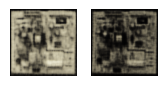

In [59]:
if experiment['TYPE'] == 'train':
  if experiment['ACCELERATOR'] == 'TPU':
      cvae_model_hist = train(train_dataset_replica, experiment['EPOCHS'])
  else:
      cvae_model_hist = train(train_dataset_part, experiment['EPOCHS'])

### Loss curve for all batches

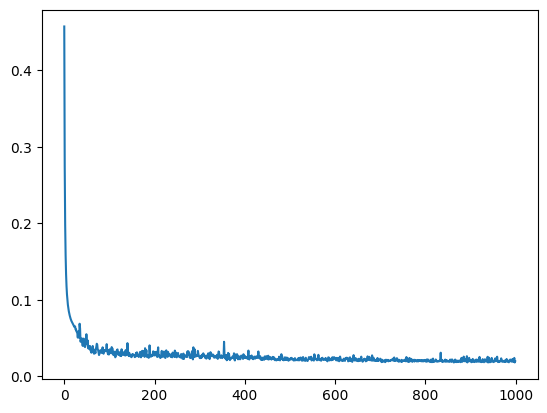

In [60]:
plt.plot(cvae_model_hist)

### Mean Loss curve

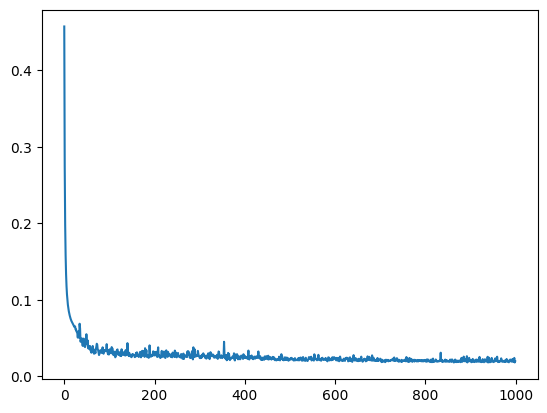

In [61]:
mean_loss = lambda x: tf.reduce_mean(x)
cvae_model_hist_mean = list(map(mean_loss, cvae_model_hist))

plt.plot(cvae_model_hist_mean)

In [62]:
TRAINING_WEIGHT_DIR = '.../tf_vae/training_weights'  # Google Drive Directory

if experiment['TYPE'] == 'test':
  # Load weigths that generated with last epoch
  encoder_model.load_weights(TRAINING_WEIGHT_DIR + '/encoder_model_'
                             + str(experiment['EPOCHS'] - 1) + '.h5')
  decoder_model.load_weights(TRAINING_WEIGHT_DIR + '/decoder_model_'
                             + str(experiment['EPOCHS'] - 1) + '.h5')

In [63]:
def get_model_embeddings(dataset, model='sampling'):
    embeddings=None
    mean=None
    var=None

    for i in dataset:
        m,v = encoder_model.predict(i)
        latent = sampling_model.predict([m,v])
        if not (model == 'sampling' or model == 'decoder'):
            raise ValueError("Valid model types= 'sampling' and 'decoder'")

        if model == 'sampling':
          embed = latent
        else:
          embed = decoder_model.predict(latent)

        if embeddings is None:
            embeddings = embed
            mean = m
            var = v
        else:
            embeddings = np.concatenate((embeddings, embed))
            mean = np.concatenate((mean, m))
            var = np.concatenate((var, v))

        if embeddings.shape[0] > 5000:
            break

    return embeddings

In [64]:
embeddings = get_model_embeddings(train_dataset_part, model='sampling')
# embeddings = get_model_embeddings(train_dataset_part, model='decoder')
embeddings.shape

1/1 [==============================] - 0s 17ms/step


(330, 500)

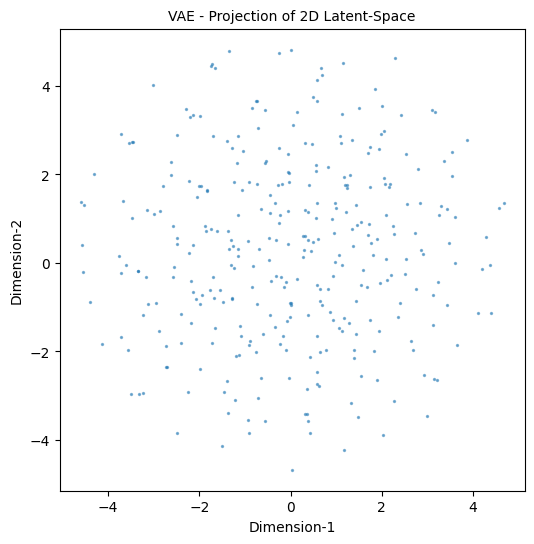

In [65]:
from sklearn.manifold import TSNE

n_to_show = 5000
grid_size = 15

tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(embeddings)

min_x = min(X_tsne[:, 0])
max_x = max(X_tsne[:, 0])
min_y = min(X_tsne[:, 1])
max_y = max(X_tsne[:, 1])

plt.figure(figsize=(6, 6))
plt.scatter(X_tsne[:, 0] , X_tsne[:, 1], alpha=0.5, s=2)
plt.xlabel("Dimension-1", size=10)
plt.ylabel("Dimension-2", size=10)
plt.xticks(size=10)
plt.yticks(size=10)
plt.title("VAE - Projection of 2D Latent-Space", size=10)
plt.show()

### Run model in Inference mode - Prediction - Generation

In [66]:
def get_generated_image_batch(data, model='decoder'):
    reconstructed_batch = None
    latent_space = None

    if not (model == 'sampling' or model == 'decoder'):
        raise ValueError("Valid model types= 'sampling' and 'decoder'")

    for image_batch in data:
      mean, log_var = encoder_model.predict(image_batch)
      latent_vector = sampling_model([mean,log_var])
      generated_batch = decoder_model.predict(latent_vector)

      if reconstructed_batch is None:
          reconstructed_batch = generated_batch
          latent_space = latent_vector
      else:
          reconstructed_batch = np.concatenate((reconstructed_batch, generated_batch))
          latent_space = np.concatenate((latent_space, latent_vector))

      if reconstructed_batch.shape[0] > 5000:
          break

    if model == 'sampling':  return latent_space
    else: return reconstructed_batch

In [67]:
generated_train_data = get_generated_image_batch(train_dataset_part.take(1))  # Use only first batch
generated_train_data.shape

1/1 [==============================] - 0s 162ms/step


(8, 512, 512, 3)

In [68]:
def show_generated_images(image_batch):
  fig = plt.figure(figsize=(10, 10))
  for index, image in enumerate(image_batch):
    plt.subplot(4, 4, index + 1)
    plt.imshow(image)
    plt.axis('off')
    if index >= 15:
      break
  plt.show()

### Generate Images from Training Data

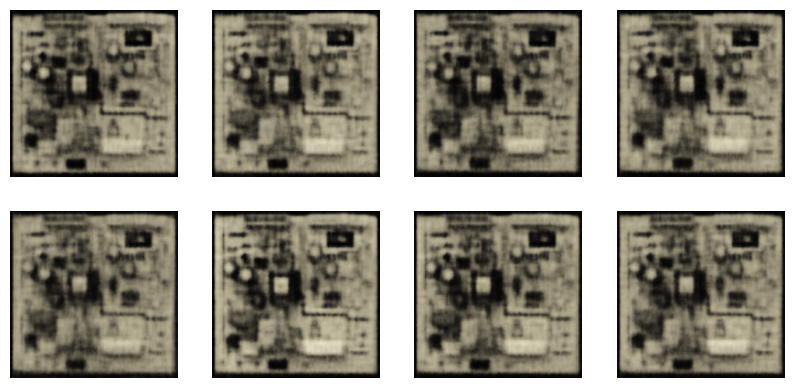

In [69]:
show_generated_images(generated_train_data)

### Generate Images from Validation Data

In [82]:
#generated_valid_data = get_generated_image_batch(valid_dataset_part.take(1))  # Use only first batch
#show_generated_images(generated_valid_data)

### Generate Images from Testing (Defected) Data

In [71]:
test_img_files = utils.get_image_file_list(BD67_DEFECTED_FRONT_PATH, 'png')

print("Number of Test image files: ", len(test_img_files))

Number of Test image files:  10


In [73]:
test_dataset = utils.create_dataset_pipeline(test_img_files, batch_size=experiment['BATCH_SIZE'], img_size=experiment['IMAGE_SIZE'], scl=True, shuffle=False, num_channels=3, rot=utils.ROT_0, aug_layer=None, data_aug_power=1, accelerator='GPU')

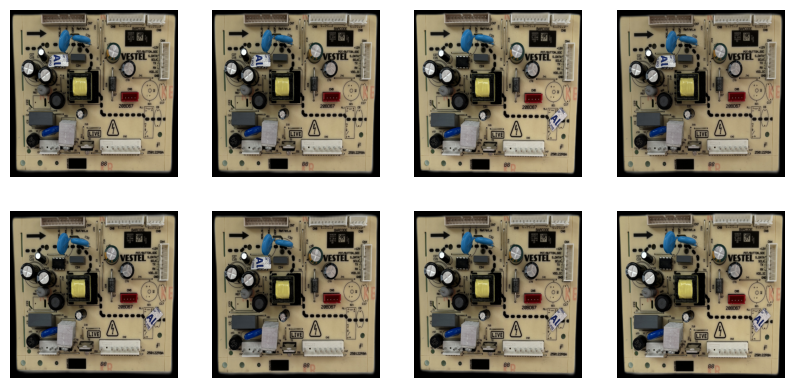

In [74]:
vision.show_image_samples_from_batch(test_dataset)

1/1 [==============================] - 0s 17ms/step


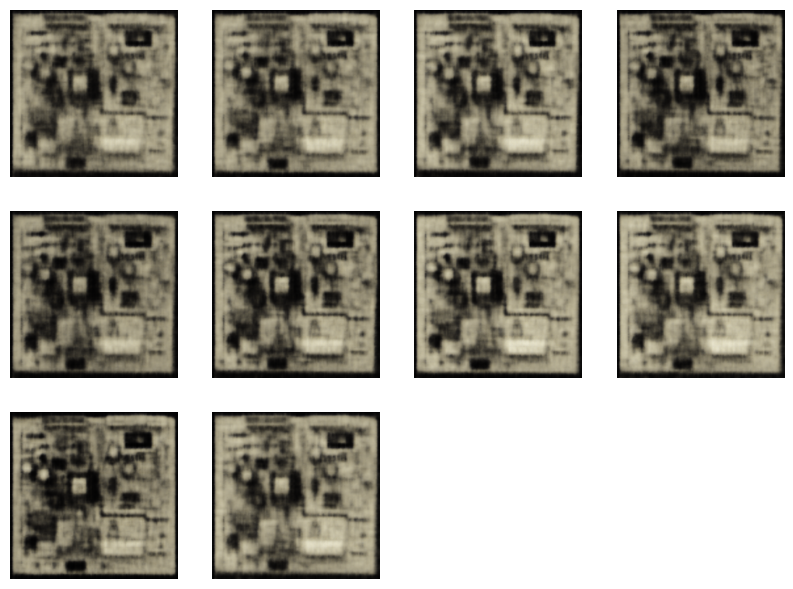

In [75]:
generated_test_data = get_generated_image_batch(test_dataset)

show_generated_images(generated_test_data)

In [76]:
def display_pixel_wise_img_diff(img1_dir, img2_dir, threshold=None, verbose=0, channel=0):
  # Load your two images using TensorFlow
  #image1 = tf.image.decode_image(tf.io.read_file(img1_dir))
  #image2 = tf.image.decode_image(tf.io.read_file(img2_dir))
  image1 = img1_dir
  image2 = img2_dir

  # Ensure both images have the same shape and data type
  image1 = tf.cast(image1, tf.float32)
  image2 = tf.cast(image2, tf.float32)

  # Compute pixel-wise absolute differences
  diff = tf.abs(image1 - image2)
  if verbose > 0:  print(f"Difference map shape: {diff.shape}")

  # Define a colormap (e.g., 'jet') and normalize the differences
  cmap = plt.get_cmap('jet')
  norm = plt.Normalize(vmin=0, vmax=tf.reduce_max(diff).numpy())
  norm_diff = norm(diff)
  if verbose > 0:
    print(f"Normalized difference map shape: {norm_diff.shape}")
    print(f"Normalized difference map min, avg, max value: ({np.min(norm_diff)}, {np.mean(norm_diff):.5f}, {np.max(norm_diff)})")

  colored_diff = cmap(norm_diff)
  if verbose > 0:  print(f"Colored difference map shape: {colored_diff.shape}")

  color_diff_plot = colored_diff[:, :, :,channel]

  if threshold != None:
    color_diff_plot[color_diff_plot < threshold] = 0.0

  # Display the color-coded difference map
  plt.imshow(color_diff_plot)
  plt.colorbar()
  plt.axis('off')
  plt.show()

May the new threshold method be proposed. Area based threshold (filtering). If the area value that obtained from sum of nearest pixels is under a limit, filter it.

Difference map shape: (512, 512, 3)
Normalized difference map shape: (512, 512, 3)
Normalized difference map min, avg, max value: (1.2929002934924938e-07, 0.12658, 1.0)
Colored difference map shape: (512, 512, 3, 4)


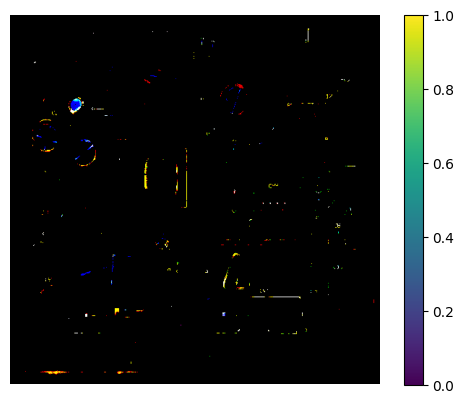

In [77]:
train_batch = next(iter(train_dataset_part))

display_pixel_wise_img_diff(train_batch[0], generated_train_data[0], threshold=0.8, channel=0, verbose=1)

In [81]:
#valid_batch = next(iter(valid_dataset_part))
#display_pixel_wise_img_diff(valid_batch[1], generated_valid_data[1], threshold=0.8, channel=0, verbose=1)

Difference map shape: (512, 512, 3)
Normalized difference map shape: (512, 512, 3)
Normalized difference map min, avg, max value: (1.2627846501800377e-07, 0.11676, 1.0)
Colored difference map shape: (512, 512, 3, 4)


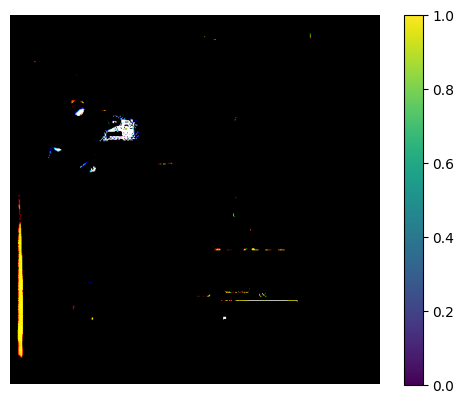

In [80]:
test_batch = next(iter(test_dataset))

display_pixel_wise_img_diff(test_batch[0], generated_test_data[0], threshold=0.8, channel=0, verbose=1)

Difference map shape: (512, 512, 3)
Normalized difference map shape: (512, 512, 3)
Normalized difference map min, avg, max value: (6.834931554067225e-08, 0.12803, 1.0)
Colored difference map shape: (512, 512, 3, 4)


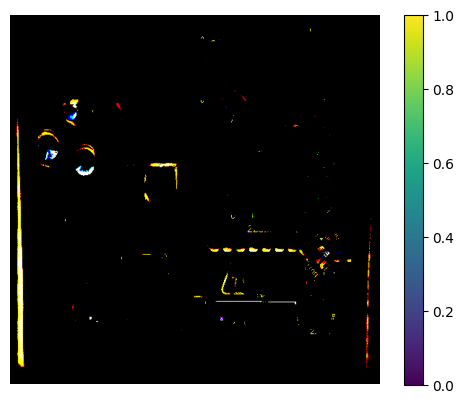

In [88]:
display_pixel_wise_img_diff(test_batch[6], generated_test_data[6], threshold=0.8, channel=0, verbose=1)

### Learning Rate Decay

In [ ]:
import math

LR_START = 1e-5
LR_MIN = 1e-5
#LR_MAX = 9e-4 * strategy.num_replicas_in_sync
LR_MAX = 9e-4
LR_RAMPUP_EPOCHS = 3
LR_SUSTAIN_EPOCHS = 0
N_CYCLES = 0.5
EPOCHS = experiment['EPOCHS']

def lrfn(epoch):
  if epoch < LR_RAMPUP_EPOCHS:
    lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
  elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
    lr = LR_MAX
  else:
    progress = (epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) / (EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS)
    lr = LR_MAX * (0.5 * (1.0 + tf.math.cos(math.pi * N_CYCLES * 2.0 * progress)))
    if LR_MIN is not None:
      lr = tf.math.maximum(LR_MIN, lr)

  return lr

In [ ]:
def predict_perpdiff(dataset, ds_imgs):
  vgg19_perp_model = tf.keras.applications.VGG19(input_shape=(224,224,3))
  modelOutputs = [vgg19_perp_model.layers[i].output for i in [12]]  # Set 12th layer for the model output layer
  vgg19_perp_model = Model(vgg19_perp_model.inputs, modelOutputs)

  for ds_imgs in dataset.take(1):
    input_imgs = ds_imgs.numpy()

    mean, log_var = encoder_model.predict(ds_imgs)
    latent_vector = sampling_model([mean,log_var])
    y_pred = decoder_model.predict(latent_vector)

    print("y_pred.shape: ", y_pred.shape)

    # Predict the reconstructed image
    #y_pred = model.predict(input_imgs)

    # Resize the images to the input size of VGG19
    y_true_reshape = tf.image.resize(input_imgs, (224, 224))
    y_pred_reshape = tf.image.resize(y_pred, (224, 224))
    # mask1_reshape = tf.image.resize(ds_imgs[1], (224, 224))
    # mask2_reshape = tf.image.resize(ds_imgs[2], (224, 224))
    print("y_true_reshape.shape: ", y_true_reshape.shape)

    # Pass all images in the VGG19 and get the perceptual layers outputs
    perp_input = vgg19_perp_model([y_true_reshape])
    perp_pred = vgg19_perp_model([y_pred_reshape])

  # return y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred
  return y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred

In [ ]:
def compute_min_max(perp_input, perp_pred):
  print("Computing min and max...")
  max_norm = 0
  min_norm = 1000000

  for img_idx in range(perp_input.shape[0]):
    perp_img = tf.math.abs( perp_input[img_idx,:,:,0] - perp_pred[img_idx,:,:,0] )

    for i in range(1, perp_input.shape[3] ):
      perp_img += tf.math.abs( perp_input[img_idx,:,:,i] - perp_pred[img_idx,:,:,i] )
      max_value = tf.math.reduce_max(perp_img)
      min_value = tf.math.reduce_min(perp_img)

      if max_value > max_norm:
        max_norm = max_value
      if min_value < min_norm:
        min_norm = min_value

  print("max_norm: {}".format(max_norm))
  print("min_norm: {}".format(min_norm))

  return min_norm, max_norm

In [ ]:
def calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm):
  y_pred_all = []
  all_perp = []

  print("Calculating anomaly map")
  for img_idx in range(perp_input.shape[0]):
      perp_img = tf.math.abs(perp_input[img_idx,:,:,0] - perp_pred[img_idx,:,:,0])
      for i in range(1, perp_input.shape[3] ):
        perp_img += tf.math.abs(perp_input[img_idx,:,:,i] - perp_pred[img_idx,:,:,i])

      perp_img =(perp_img - min_norm) / (max_norm - min_norm)

      perp_img = tf.image.resize(tf.expand_dims(perp_img, axis=2), (224,224))
      perp_img = tf.squeeze(perp_img)

      all_perp.append(perp_img)
      y_pred_all.append( perp_img.numpy().ravel() )

  return all_perp, y_pred_all

In [ ]:
# Predict all images for training data
# y_true_reshape, y_pred_reshape, perp_input, perp_pred, mask2_reshape, y_pred = predict_perpdiff(test_dataset, autoencoder_model)
y_true_reshape, y_pred_reshape, perp_input, perp_pred, y_pred = predict_perpdiff(test_dataset, test_dataset)

# Get min max for normalization
min_norm, max_norm = compute_min_max(perp_input, perp_pred)

# Calculate perceptual anomaly map
all_perp, y_pred_all = calculate_anomaly_map(perp_input, perp_pred, min_norm, max_norm)
show_generated_images(all_perp)